In [0]:
#--------------------------------------------------------------------------------------------------------------
#!pip install nuscenes-devkit
#--------------------------------------------------------------------------------------------------------------

In [0]:
#from nuscenes.nuscenes import NuScenes
#from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
import pandas as pd
import numpy as np
import glob
import cv2
import os


In [9]:
datafile = "./drive/My Drive/v1.0-mini/data/Final_Data_2_Changed.csv"
#datafile = "./drive/My Drive/v1.0-mini/data/Final_Sample_Wise_changed.csv"
dataframe = pd.read_csv(datafile)
dataframe.head()

,index,lidar_top,radar_front,radar_front_left,radar_front_right,radar_back_left,radar_back_right,montage_image,bbox_size,num_lidar_pts,num_radar_pts,visibility_token,category_name
0,0,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.621, 0.669, 1.642]",1,0,1,pedestrian
1,1,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.775, 0.769, 1.711]",2,0,2,pedestrian
2,2,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[2.011, 4.633, 1.573]",5,0,3,vehicle_small
3,3,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.752, 0.819, 1.637]",1,0,4,pedestrian
4,4,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.427, 0.359, 0.794]",1,0,4,small_objects


In [10]:
labels = dataframe['category_name']
cont_data = dataframe[['num_lidar_pts','num_radar_pts','visibility_token']]
cont_data.head()

,num_lidar_pts,num_radar_pts,visibility_token
0,1,0,1
1,2,0,2
2,5,0,3
3,1,0,4
4,1,0,4


In [0]:
#------------------------------------------------------------
# importing libraries
#------------------------------------------------------------
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

import keras
from keras.models import Model
from keras import layers
from keras.layers import Dense, Dropout, Input


# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 32

In [0]:
from sklearn import preprocessing
#------------------------------------------------------------------
# Encoding Labels
le = LabelEncoder()
le.fit(labels)
labels_encoded = le.transform(labels)
le.classes_
len(labels_encoded)

mnN = preprocessing.MinMaxScaler()
datasNorm = pd.DataFrame(mnN.fit_transform(cont_data.values))

#------------------------------------------------------------------
#------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(datasNorm, labels_encoded, test_size=0.20, random_state=910)
#train = np.array(X_train)
#print(train.shape)

In [0]:
def create_mlp(dim, classess):
	inputshape = dim
	inputs = Input(shape=inputshape)
	
	x = Dense(512, name="cont_dense_512")(inputs)
	x = Dropout(0.5, name="cont_drop512")(x)
 
	for size in [256, 128, 64, 32, 16]:	
		x	=	Dense(size, activation = "relu", name="cont_dense"+str(size))(x)
		x = Dropout(0.5, name="cont_drop"+str(size))(x)
		x = layers.BatchNormalization(name="cont_"+str(size))(x)
	
	x = Dense(8, name="cont_dense8")(x)
	x = layers.BatchNormalization(name="cont_dense8final")(x)
	x = Dense(classess, activation="softmax", name="cont_output5")(x)
	
	# return our model
	return keras.Model(inputs, x)


In [0]:
model = create_mlp((3,), 4)
keras.utils.plot_model(model, show_shapes=True)
#------------------------------------------------------------------
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
cont_dense_512 (Dense)       (None, 512)               2048      
_________________________________________________________________
cont_drop512 (Dropout)       (None, 512)               0         
_________________________________________________________________
cont_dense256 (Dense)        (None, 256)               131328    
_________________________________________________________________
cont_drop256 (Dropout)       (None, 256)               0         
_________________________________________________________________
cont_256 (BatchNormalization (None, 256)               1024      
_________________________________________________________________
cont_dense128 (Dense)        (None, 128)               3289

In [0]:
#------------------------------------------------------------------
# Training Model
#------------------------------------------------------------------
callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
Hist = model.fit(
    X_train, y_train, epochs = EPOCHS, validation_data = (X_test, y_test), shuffle="true"
)
#------------------------------------------------------------------

Train on 14830 samples, validate on 3708 samples
Epoch 1/100
14830/14830 [==============================] - 5s 317us/step - loss: 1.2448 - accuracy: 0.4399 - val_loss: 1.2186 - val_accuracy: 0.4496
Epoch 2/100
14830/14830 [==============================] - 4s 239us/step - loss: 1.2130 - accuracy: 0.4504 - val_loss: 1.1542 - val_accuracy: 0.4782
Epoch 3/100
14830/14830 [==============================] - 4s 238us/step - loss: 1.1636 - accuracy: 0.4575 - val_loss: 1.1070 - val_accuracy: 0.4566
Epoch 4/100
14830/14830 [==============================] - 4s 245us/step - loss: 1.1544 - accuracy: 0.4617 - val_loss: 1.1031 - val_accuracy: 0.4995
Epoch 5/100
14830/14830 [==============================] - 4s 241us/step - loss: 1.1441 - accuracy: 0.4635 - val_loss: 1.1099 - val_accuracy: 0.5013
Epoch 6/100
14830/14830 [==============================] - 4s 247us/step - loss: 1.1435 - accuracy: 0.4633 - val_loss: 1.1100 - val_accuracy: 0.4569
Epoch 7/100
14830/14830 [==============================] 

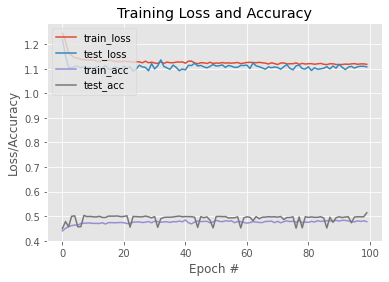

In [0]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), Hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), Hist.history["val_loss"], label="test_loss")
plt.plot(np.arange(0, N), Hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), Hist.history["val_accuracy"], label="test_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

In [0]:
#------------------------------------------------------------------
# Saving Model for later use
#------------------------------------------------------------------
model.save("./drive/My Drive/v1.0-mini/model/cont_model.h5")  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = keras.models.load_model("./drive/My Drive/Amit/my_model.h5")
#------------------------------------------------------------------

In [13]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 4031],
       [   1, 3078],
       [   2, 1055],
       [   3, 6666]])

In [14]:
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 1009],
       [   1,  772],
       [   2,  260],
       [   3, 1667]])